In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import importlib

import prompts as promptlib
import gpt
import config
importlib.reload(promptlib)
importlib.reload(gpt)
importlib.reload(config)

fname = "synthetic_smart_v2.csv"
df = pd.read_csv(fname)
display(df.head())

json_schema = promptlib.SMARTFeedback.model_json_schema()

def add_feedback_prompt(row: pd.Series):
    draft = promptlib.SMARTResponse(smart=row["smart"], plan=row["plan"])
    prompt = promptlib.PROMPT_SMART_FEEDBACK.format(
        FEEDBACK_PRINCIPLES=promptlib.FEEDBACK_PRINCIPLES,
        SMART_RUBRIC=promptlib.SMART_RUBRIC,
        SMART_EXAMPLE=promptlib.SMART_EXAMPLE,
        student_draft=draft.model_dump_json(indent=2),
        json_schema=json_schema,
    )
    return prompt

df['feedback_prompt'] = df.apply(add_feedback_prompt, axis=1)

,skill,prompt,tone,errors,smart,plan
0,voice volume,You're a student taking a course where you're ...,persuasive,NaN,Improve my voice volume during educational pre...,I will achieve this by practicing projecting m...
1,voice volume,You're a student taking a course where you're ...,objective,NaN,Increase my voice volume during presentations ...,I will start by setting aside time each day to...
2,pitch and intonation,You're a student taking a course where you're ...,authoritative,NaN,Use varying pitches and intonations in my pres...,I will achieve this by recording myself practi...
3,pitch and intonation,You're a student taking a course where you're ...,humorous,NaN,Use varied pitches and intonations in my prese...,I will achieve this by recording myself practi...
4,language use,You're a student taking a course where you're ...,sympathetic,NaN,Effortlessly incorporate precise and professio...,I will achieve this by first reviewing my past...


In [28]:
# generate feedback for ALL rows
config.source_dot_env()  # read api key
model = gpt.GPTModel()
outputs, meta = model(list(df["feedback_prompt"]))
print(f"price = ${model.compute_price(meta):.3f}")


price = $0.062


num_errors = 0
error_indices =  []


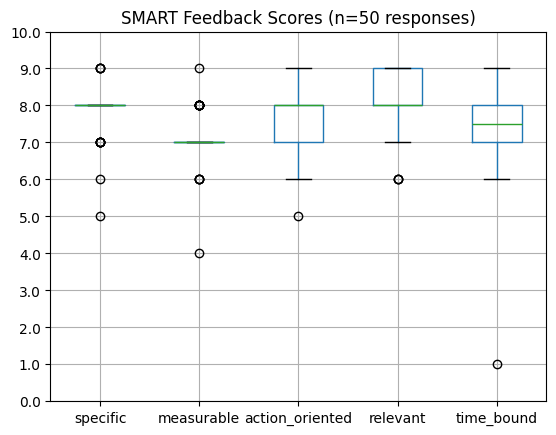

summary of scores:


,specific,measurable,action_oriented,relevant,time_bound
count,50.000000,50.000000,50.00000,50.000000,50.00000
mean,7.840000,7.120000,7.48000,8.120000,7.28000
std,0.680936,0.746147,0.81416,0.798979,1.16128
min,5.000000,4.000000,5.00000,6.000000,1.00000
25%,8.000000,7.000000,7.00000,8.000000,7.00000
50%,8.000000,7.000000,8.00000,8.000000,7.50000
75%,8.000000,7.000000,8.00000,9.000000,8.00000
max,9.000000,9.000000,9.00000,9.000000,9.00000


In [70]:
importlib.reload(promptlib)
# post process outputs
feedback_objs = []
error_indices = []
for i, response in enumerate(outputs):
    try:
        feedback = promptlib.parseSMARTFeedback(response, retry=True)
    except Exception as e:
        # TODO: consider reprompting with context (up to 1 additional time per invalid response)
        feedback = None
        # this is a hack for 1/50 responses
        bad = '"score": null'
        if bad in response:
            tmp = response.replace('"score": null', '"score": 1')
            feedback = promptlib.parseSMARTFeedback(tmp, retry=True)

    feedback_objs.append(feedback)

error_indices = [i for i, x in enumerate(feedback_objs) if x is None]
print(f"num_errors = {len(error_indices)}")
print("error_indices = ", error_indices)
assert len(error_indices) == 0

# extract numerical scores
scores_data = {}
pretty_data = {}
pretty_data["feedback_raw"] = outputs
for attr in promptlib.SMART:
    attr = attr.replace("-", "_").lower()
    scores_data[attr] = [getattr(obj, attr).score for obj in feedback_objs]

    pretty_data["overall_feedback"] = [obj.overall_feedback for obj in feedback_objs]
    pretty_data[f"feedback_{attr}"] = [getattr(obj, attr).feedback for obj in feedback_objs]
    pretty_data[f"score_{attr}"] = [getattr(obj, attr).score for obj in feedback_objs]

scores_df = pd.DataFrame(scores_data)
scores_df.boxplot()
# set y-axis to 0-10, tickmarks every 0.5
plt.yticks(range(0, 11), [f"{x:.1f}" for x in range(0, 11)])
plt.title(f"SMART Feedback Scores (n={len(scores_df)} responses)")
plt.show()

print("summary of scores:")
scores_df.describe()


In [68]:
pretty_df = pd.DataFrame(pretty_data)
new_df = pd.concat([df, pretty_df], axis=1)
# write to csv
output_path = "synthetic_smart_v2__feedback.csv"
new_df.to_csv(output_path, index=False)
print(f"wrote '{output_path}'")

new_df = pd.read_csv(output_path)
new_df.head()

wrote 'synthetic_smart_v2__feedback.csv'


,skill,prompt,tone,errors,smart,plan,feedback_prompt,feedback_raw,overall_feedback,feedback_specific,score_specific,feedback_measurable,score_measurable,feedback_action_oriented,score_action_oriented,feedback_relevant,score_relevant,feedback_time_bound,score_time_bound
0,voice volume,You're a student taking a course where you're ...,persuasive,NaN,Improve my voice volume during educational pre...,I will achieve this by practicing projecting m...,"\nYou are a peer reviewer, tasked with giving ...",The student's draft shows a good understanding...,Great job on formulating a SMART goal and acti...,The goal of improving voice volume during educ...,8,The plan to assess volume levels during presen...,7,The action plan of practicing voice projection...,7,The goal of improving voice volume is relevant...,8,Consider setting a specific deadline for achie...,7
1,voice volume,You're a student taking a course where you're ...,objective,NaN,Increase my voice volume during presentations ...,I will start by setting aside time each day to...,"\nYou are a peer reviewer, tasked with giving ...","In reviewing your SMART goal and action plan, ...",Well done on creating a SMART goal and action ...,Your goal is specific and clearly defines the ...,9,Your plan includes measurable actions to track...,8,You have outlined specific actions to take to ...,8,Your goal is relevant to the context of presen...,8,You have established a realistic timeline for ...,8
2,pitch and intonation,You're a student taking a course where you're ...,authoritative,NaN,Use varying pitches and intonations in my pres...,I will achieve this by recording myself practi...,"\nYou are a peer reviewer, tasked with giving ...",The student's SMART goal and action plan are g...,"Overall, the student has shown a good understa...",The goal is specific and clearly defined. Cons...,8,The goal could be more robustly measurable by ...,7,The action plan outlines concrete steps to ach...,8,The goal is relevant to the learning objective...,9,The goal specifies when it will be achieved an...,8
3,pitch and intonation,You're a student taking a course where you're ...,humorous,NaN,Use varied pitches and intonations in my prese...,I will achieve this by recording myself practi...,"\nYou are a peer reviewer, tasked with giving ...","In analyzing the student's work, it aligns qui...",Well done on creating a SMART goal with a prac...,The specific goal of using varied pitches and ...,8,The goal's measurability through recording and...,7,The action-oriented nature of practicing diffe...,8,The goal of engaging the audience with varied ...,8,The goal is time-bound and outlines achieving ...,8
4,language use,You're a student taking a course where you're ...,sympathetic,NaN,Effortlessly incorporate precise and professio...,I will achieve this by first reviewing my past...,"\nYou are a peer reviewer, tasked with giving ...",After reviewing your SMART goal and action pla...,Your proactive approach towards improving your...,Your SMART goal is specific and action-oriente...,8,Consider adding specific criteria or examples ...,7,Your action plan outlines clear steps to achie...,8,Ensure that the use of scientific terminology ...,8,"While your goal is time-bound, consider settin...",7
